<a href="https://colab.research.google.com/github/YuxuanHuang455/PS-Microexpression/blob/main/Prediction_of_%22Microexpression_basic_EDA_ipynb%E2%80%9D_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Microexpression-PS2-prediction code



Machine Learning for Prediction
1. Algorithm Selection
Use at least three different algorithms (e.g., logistic regression, random forest, gradient boosting, AutoGluon multimodal). Justify choices based on dataset type (tabular, time-series, or multimodal).
2. Evaluation
Compare predictive performance using relevant metrics (accuracy, F1, RMSE,
AUC, etc.). Summarize results with tables and plots.
3. Discussion
Interpret comparative results. Reflect on trade-offs and social science implications.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
gdrive_path = "/content/drive/MyDrive"
dataset_path = os.path.join(gdrive_path, "data")
print("data:", dataset_path)
print("folder:", os.listdir(dataset_path))


data: /content/drive/MyDrive/data
folder: ['.DS_Store', 'test', 'train']


summaries, visualizations, missing data check

=== Training splits (per label) ===


,train1,train2,train3,total
happy,7215,1950,1500,10665
sad,4830,1383,1500,7713
anger,3995,1411,1522,6928
fear,4097,479,1500,6076
surprise,3171,1114,1505,5790
neutral,4965,644,0,5609
disgust,436,662,1500,2598


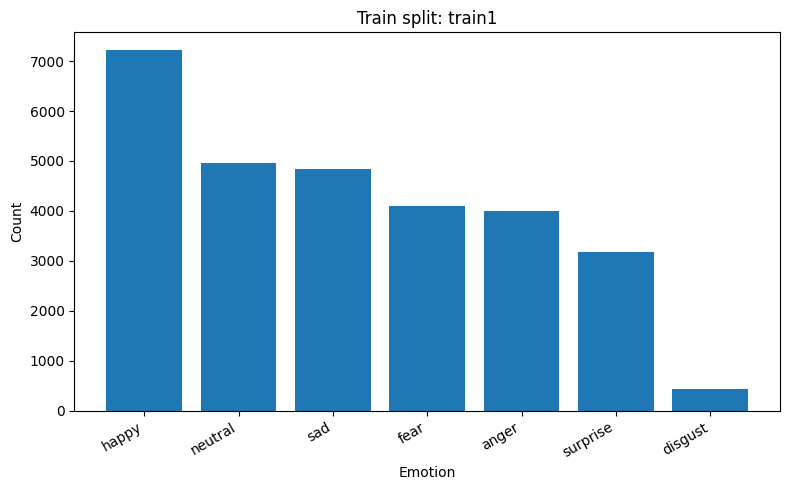

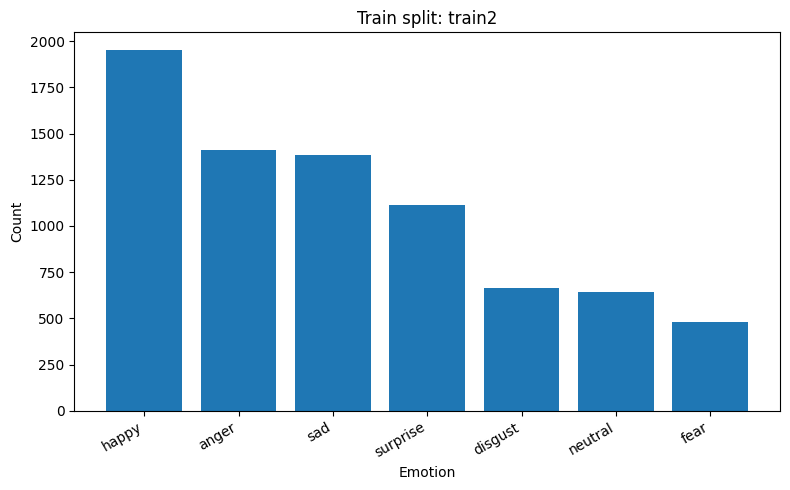

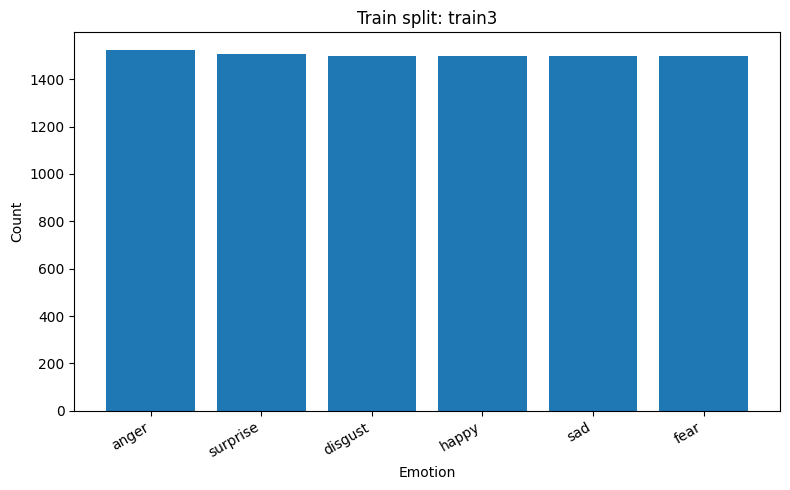

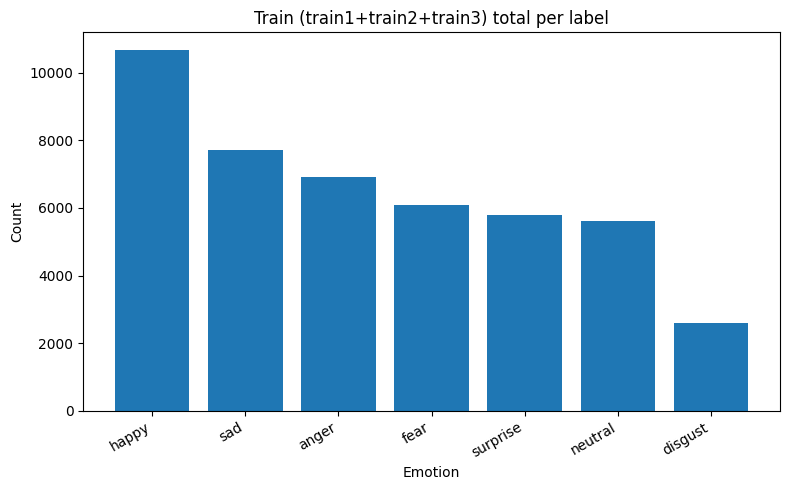

In [4]:
import os
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

DATA_ROOT = "/content/drive/MyDrive/data"
TRAIN_ROOT = os.path.join(DATA_ROOT, "train")
TEST_ROOT  = os.path.join(DATA_ROOT, "test")
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

def is_image_file(fname: str) -> bool:
    return os.path.splitext(fname)[1].lower() in IMG_EXTS
CANONICAL_MAP = {
    "happiness": "happy",
    "angry": "anger",
    "disgusted": "disgust",
    "surprised": "surprise",
    "sadness": "sad",
}

def canonicalize(label: str) -> str:
    lab = label.strip().lower()
    return CANONICAL_MAP.get(lab, lab)

def count_split(root_dir: str, split_name: str) -> dict:

    counts = defaultdict(int)
    if not os.path.isdir(root_dir):
        print(f"[WARN] {split_name} 路径不存在：{root_dir}")
        return {}

    for entry in os.listdir(root_dir):
        if entry.startswith("."):
            continue
        class_dir = os.path.join(root_dir, entry)
        if not os.path.isdir(class_dir):
            continue
        label = canonicalize(entry)
        for r, _, files in os.walk(class_dir):
            for f in files:
                if is_image_file(f):
                    counts[label] += 1
    return dict(counts)

def counts_to_dataframe(split_counts: dict, split_order: list) -> pd.DataFrame:

    all_labels = set()
    for c in split_counts.values():
        all_labels.update(c.keys())
    all_labels = sorted(all_labels)
    df = pd.DataFrame(index=all_labels, columns=split_order, data=0)
    for split, cdict in split_counts.items():
        for lab, n in cdict.items():
            df.loc[lab, split] = n
    df["total"] = df[split_order].sum(axis=1)
    df = df.sort_values("total", ascending=False)
    return df

def barplot_counts(df: pd.DataFrame, title: str):
    plt.figure(figsize=(8,5))
    plt.bar(df.index, df["total"])
    plt.title(title)
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

#Stats train1 / train2 / train3
train_splits = ["train1", "train2", "train3"]
train_counts = {}
for s in train_splits:
    split_dir = os.path.join(TRAIN_ROOT, s)
    train_counts[s] = count_split(split_dir, s)

df_train = counts_to_dataframe(train_counts, train_splits)
print("=== Training splits (per label) ===")
display(df_train)

for s in train_splits:
    df_s = pd.DataFrame(train_counts[s], index=[0]).T
    df_s.columns = ["count"]
    df_s = df_s.sort_values("count", ascending=False)
    barplot_counts(df_s.assign(total=df_s["count"]), f"Train split: {s}")

# train1+2+3
barplot_counts(df_train, "Train (train1+train2+train3) total per label")

=== Test splits (per label) ===


,test1,test2,total
happy,207,480,687
surprise,249,260,509
anger,135,350,485
sad,84,330,414
disgust,177,160,337
fear,75,120,195
neutral,0,160,160
contempt,54,0,54


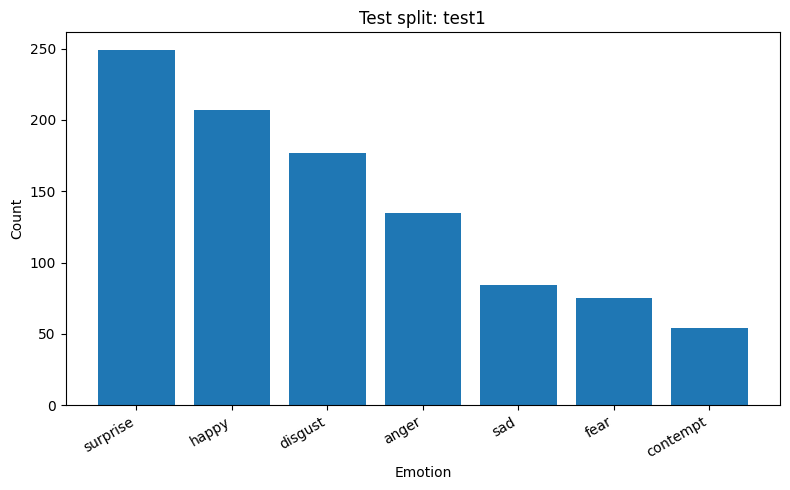

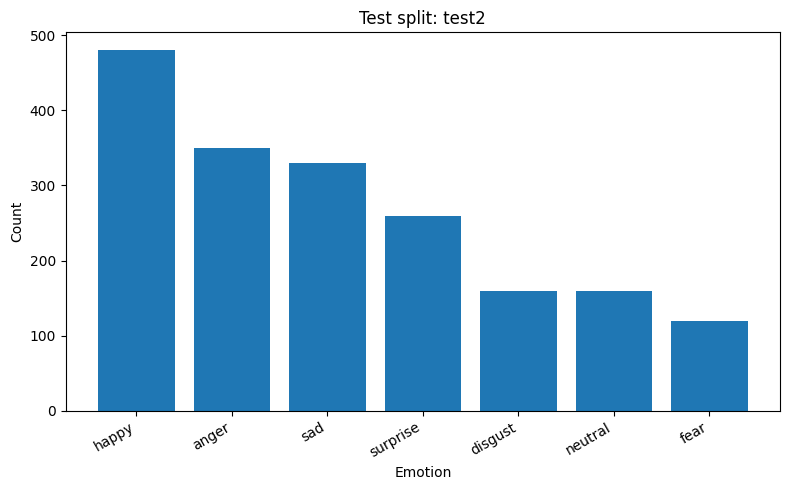

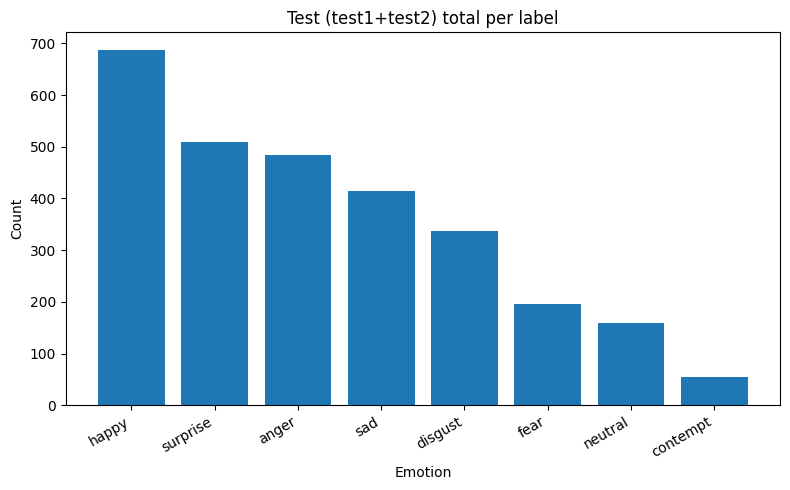

In [5]:
#Stats test1 / test2
test_splits = ["test1", "test2"]
test_counts = {}
for s in test_splits:
    split_dir = os.path.join(TEST_ROOT, s)
    test_counts[s] = count_split(split_dir, s)

df_test = counts_to_dataframe(test_counts, test_splits)
print("=== Test splits (per label) ===")
display(df_test)

for s in test_splits:
    df_s = pd.DataFrame(test_counts[s], index=[0]).T
    df_s.columns = ["count"]
    df_s = df_s.sort_values("count", ascending=False)
    barplot_counts(df_s.assign(total=df_s["count"]), f"Test split: {s}")

barplot_counts(df_test, "Test (test1+test2) total per label")

In [6]:
# Summary for Most and Minority
top_k = 2
tail_k = 2

majority = df_train["total"].nlargest(top_k)
minority = df_train["total"].nsmallest(tail_k)
majority = df_test["total"].nlargest(top_k)
minority = df_test["total"].nsmallest(tail_k)

print("\n>>> Training set - Most classes (Top {}):".format(top_k))
display(majority.to_frame(name="count"))

print(">>> Training set - Minority Classes (Bottom {}):".format(tail_k))
display(minority.to_frame(name="count"))

print("\n>>> Test set - Most classes (Top {}):".format(top_k))
display(majority.to_frame(name="count"))

print(">>> Test set - Minority Classes (Bottom {}):".format(tail_k))
display(minority.to_frame(name="count"))

print("\n The above statistics have incorporated common variants (for example, happiness→happy, surprised→surprise, sadness→sad).。")



>>> Training set - Most classes (Top 2):


,count
happy,687
surprise,509


>>> Training set - Minority Classes (Bottom 2):


,count
contempt,54
neutral,160



>>> Test set - Most classes (Top 2):


,count
happy,687
surprise,509


>>> Test set - Minority Classes (Bottom 2):


,count
contempt,54
neutral,160



 The above statistics have incorporated common variants (for example, happiness→happy, surprised→surprise, sadness→sad).。


part2: micro_expression_classification

In [7]:
# importing required libraries
import os
import torch
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from keras.utils import to_categorical
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Attention, GlobalAveragePooling2D, Reshape, MultiHeadAttention
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from keras.models import Model
from sklearn.metrics import classification_report

In [9]:
import os

ROOT = "/content/drive/MyDrive/data"
for split_root, splits in [("train", ["train1","train2","train3"]),
                           ("test",  ["test1","test2"])]:
    base = os.path.join(ROOT, split_root)
    print(f"\n[{split_root}] base exists?", os.path.isdir(base), "->", base)
    for s in splits:
        p = os.path.join(base, s)
        print(" ", s, "exists?", os.path.isdir(p))
        if os.path.isdir(p):
            sub = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p,d)) and not d.startswith(".")]
            print("   classes level-1:", sub[:10], " ... total:", len(sub))


[train] base exists? True -> /content/drive/MyDrive/data/train
  train1 exists? True
   classes level-1: ['disgust', 'anger', 'fear', 'neutral', 'surprised', 'sad', 'happy']  ... total: 7
  train2 exists? True
   classes level-1: ['disgust', 'anger', 'happiness', 'neutral', 'sadness', 'surprise', 'fear']  ... total: 7
  train3 exists? True
   classes level-1: ['disgust', 'anger', 'happiness', 'sadness', 'surprise', 'fear']  ... total: 6

[test] base exists? True -> /content/drive/MyDrive/data/test
  test1 exists? True
   classes level-1: ['disgust', 'anger', 'surprised', 'fear', 'sad', 'contempt', 'happy']  ... total: 7
  test2 exists? True
   classes level-1: ['disgust', 'anger', 'happiness', 'neutral', 'sadness', 'surprise', 'fear']  ... total: 7


In [10]:
import os
from collections import Counter
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
def is_img(p): return os.path.splitext(p)[1].lower() in IMG_EXTS

def collect_samples(root, splits):

    cls_set = set()
    for s in splits:
        split_dir = os.path.join(root, s)
        if not os.path.isdir(split_dir):
            continue
        for c in os.listdir(split_dir):
            if c.startswith("."):
                continue
            class_dir = os.path.join(split_dir, c)
            if os.path.isdir(class_dir):
                cls_set.add(c.strip())
    classes = sorted(list(cls_set))
    class_to_idx = {c:i for i,c in enumerate(classes)}
    samples = []
    for s in splits:
        split_dir = os.path.join(root, s)
        if not os.path.isdir(split_dir):
            continue
        for c in os.listdir(split_dir):
            if c.startswith("."):
                continue
            class_dir = os.path.join(split_dir, c)
            if not os.path.isdir(class_dir):
                continue
            if c not in class_to_idx:
                continue
            idx = class_to_idx[c]
            for r, _, files in os.walk(class_dir):
                for f in files:
                    if is_img(f):
                        samples.append((os.path.join(r, f), idx))
    return samples, classes, class_to_idx

DATA_ROOT   = "/content/drive/MyDrive/data"
TRAIN_ROOT  = os.path.join(DATA_ROOT, "train")
TRAIN_SPLITS = ["train1", "train2", "train3"]

train_samples, classes, class_to_idx = collect_samples(TRAIN_ROOT, TRAIN_SPLITS)
print("Classes:", classes)
print("Train size:", len(train_samples))

if len(train_samples) == 0:
    print("[ERROR] No training images were found：")
    for s in TRAIN_SPLITS:
        p = os.path.join(TRAIN_ROOT, s)
        print(" -", p, "exist？", os.path.isdir(p))
        if os.path.isdir(p):
            print("   subitem：", [d for d in os.listdir(p) if not d.startswith(".")])
    raise SystemExit

# Count the number of samples for each type
from collections import Counter
train_counts = Counter([y for _, y in train_samples])
print("Per-class counts:", {classes[i]: c for i, c in train_counts.items()})

# WeightedRandomSampler
class_sample_count = np.array([train_counts.get(i, 0) for i in range(len(classes))], dtype=np.float64)
class_sample_count[class_sample_count == 0] = 1.0
class_weights = 1.0 / class_sample_count
sample_weights = np.array([class_weights[y] for _, y in train_samples], dtype=np.float64)

if sample_weights.size == 0:
    print("[WARN] If sample_weights is empty, use shuffle=True to fall back")
    sampler = None
else:
    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(sample_weights).double(),
        num_samples=int(sample_weights.size),
        replacement=True
    )


Classes: ['anger', 'disgust', 'fear', 'happiness', 'happy', 'neutral', 'sad', 'sadness', 'surprise', 'surprised']
Train size: 45379
Per-class counts: {'disgust': 2598, 'anger': 6928, 'fear': 6076, 'neutral': 5609, 'surprised': 3171, 'sad': 4830, 'happy': 7215, 'happiness': 3450, 'sadness': 2883, 'surprise': 2619}


In [11]:
def scan_samples(root_dir, allowed_labels=None):
    samples = []
    for entry in os.listdir(root_dir):
        if entry.startswith("."): continue
        class_dir = os.path.join(root_dir, entry)
        if not os.path.isdir(class_dir): continue
        label = canonicalize(entry)   # 把文件夹名映射成标准情绪标签
        if allowed_labels and label not in allowed_labels:
            continue
        for r, _, files in os.walk(class_dir):
            for f in files:
                if is_image_file(f):
                    samples.append((os.path.join(r,f), label))
    return samples

# train/test 分别扫描
train_samples = scan_samples(TRAIN_ROOT)
test_samples  = scan_samples(TEST_ROOT)

# 确定所有类别
classes = sorted(set([lab for _, lab in train_samples] + [lab for _, lab in test_samples]))
name2idx = {c:i for i,c in enumerate(classes)}

train_samples = [(p, name2idx[lab]) for p, lab in train_samples]
test_samples  = [(p, name2idx[lab]) for p, lab in test_samples]


In [12]:
print("First 5 train samples:", train_samples[:5])
print("First 5 test samples:", test_samples[:5])


First 5 train samples: [('/content/drive/MyDrive/data/train/train1/disgust/20706.jpg', 2), ('/content/drive/MyDrive/data/train/train1/disgust/21744.jpg', 2), ('/content/drive/MyDrive/data/train/train1/disgust/25095.jpg', 2), ('/content/drive/MyDrive/data/train/train1/disgust/16815.jpg', 2), ('/content/drive/MyDrive/data/train/train1/disgust/14041.jpg', 2)]
First 5 test samples: [('/content/drive/MyDrive/data/test/test2/disgust/disgust139.jpg', 1), ('/content/drive/MyDrive/data/test/test2/disgust/disgust1.jpg', 1), ('/content/drive/MyDrive/data/test/test2/disgust/disgust154.jpg', 1), ('/content/drive/MyDrive/data/test/test2/disgust/disgust131.jpg', 1), ('/content/drive/MyDrive/data/test/test2/disgust/disgust13.jpg', 1)]


In [17]:

import os, random
import numpy as np
from sklearn.preprocessing import LabelEncoder

CANONICAL_MAP = {
    "happiness": "happy",
    "angry": "anger",
    "disgusted": "disgust",
    "surprised": "surprise",
    "sadness": "sad",

}

def canonicalize(label: str) -> str:
    lab = label.strip().lower()
    return CANONICAL_MAP.get(lab, lab)

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
def is_image_file(fname: str) -> bool:
    return os.path.splitext(fname)[1].lower() in IMG_EXTS

def scan_samples(root_dir):
    samples = []
    for split in os.listdir(root_dir):
        split_dir = os.path.join(root_dir, split)
        if not os.path.isdir(split_dir): continue
        for cls in os.listdir(split_dir):
            if cls.startswith("."): continue
            cls_dir = os.path.join(split_dir, cls)
            if not os.path.isdir(cls_dir): continue
            label = canonicalize(cls)
            for r, _, files in os.walk(cls_dir):
                for f in files:
                    if is_image_file(f):
                        samples.append((os.path.join(r,f), label))
    return samples


train_samples_raw = scan_samples(TRAIN_ROOT)
test_samples_raw  = scan_samples(TEST_ROOT)


train_samples_raw = random.sample(train_samples_raw, min(1000, len(train_samples_raw)))
test_samples_raw  = random.sample(test_samples_raw,  min(200, len(test_samples_raw)))


train_paths, train_labels = zip(*train_samples_raw)
test_paths,  test_labels  = zip(*test_samples_raw)


all_labels = list(train_labels) + list(test_labels)
le = LabelEncoder()
le.fit(all_labels)

y_tr_enc = le.transform(train_labels)
y_te_enc = le.transform(test_labels)


unique_classes = np.unique(y_tr_enc)
map_old2new = {old:new for new, old in enumerate(unique_classes)}
y_tr_enc = np.array([map_old2new[y] for y in y_tr_enc])
y_te_enc = np.array([map_old2new.get(y, -1) for y in y_te_enc])


mask = y_te_enc != -1
X_test_paths = np.array(test_paths)[mask]
y_te_enc = y_te_enc[mask]

train_samples = list(zip(train_paths, y_tr_enc))
test_samples  = list(zip(X_test_paths, y_te_enc))

print("Original classes (all):", le.classes_)
print("Classes kept in this run:", unique_classes)
print("Train size:", len(train_samples), " Test size:", len(test_samples))
print("Unique train labels:", np.unique(y_tr_enc))
print("Unique test labels:", np.unique(y_te_enc))



Original classes (all): ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Classes kept in this run: [0 2 3 4 5 6 7]
Train size: 1000  Test size: 196
Unique train labels: [0 1 2 3 4 5 6]
Unique test labels: [0 1 2 3 4 5 6]


In [18]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torchvision.models as models

from torchvision.models import MobileNet_V2_Weights
weights = MobileNet_V2_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

transform = T.Compose([
    T.Resize((128,128)),
    T.Grayscale(num_output_channels=3),
    preprocess,
])

class FeatDataset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        img = Image.open(p).convert("RGB")
        return self.transform(img), y

loader_tr = DataLoader(FeatDataset(train_samples, transform), batch_size=64,
                       shuffle=False, num_workers=2, pin_memory=True)
loader_te = DataLoader(FeatDataset(test_samples, transform), batch_size=64,
                       shuffle=False, num_workers=2, pin_memory=True)

print("DataLoader ready (sampled dataset)!")


DataLoader ready (sampled dataset)!


In [19]:
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

backbone = models.mobilenet_v2(weights=weights).to(device)
backbone.eval()
feature_extractor = torch.nn.Sequential(backbone.features, torch.nn.AdaptiveAvgPool2d(1)).to(device)

@torch.no_grad()
def extract_embeddings(loader):
    embs, ys = [], []
    for x, y in loader:
        x = x.to(device)
        f = feature_extractor(x).squeeze(-1).squeeze(-1)
        embs.append(f.cpu().numpy()); ys.append(np.asarray(y))
    return np.concatenate(embs), np.concatenate(ys)

print(">>> Extracting features...")
X_tr, y_tr = extract_embeddings(loader_tr)
X_te, y_te = extract_embeddings(loader_te)
print("Train features:", X_tr.shape, " Test features:", X_te.shape)


pca = PCA(n_components=32, random_state=42)
X_tr_p = pca.fit_transform(X_tr)
X_te_p = pca.transform(X_te)


def eval_model(model, Xtr, ytr, Xte, yte, name, results):
    model.fit(Xtr, ytr)
    yp = model.predict(Xte)
    acc = accuracy_score(yte, yp)
    f1m = f1_score(yte, yp, average="macro")
    f1w = f1_score(yte, yp, average="weighted")
    print(f"{name} | Acc={acc:.4f}, MacroF1={f1m:.4f}, WeightedF1={f1w:.4f}")
    results.append({"Method": name, "Acc": acc, "MacroF1": f1m, "WeightedF1": f1w})

results = []
eval_model(LogisticRegression(max_iter=1000, solver="saga", multi_class="multinomial"),
           X_tr_p, y_tr, X_te_p, y_te, "Logistic Regression", results)
eval_model(RandomForestClassifier(n_estimators=100, random_state=42),
           X_tr_p, y_tr, X_te_p, y_te, "Random Forest", results)
eval_model(XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42,
                         eval_metric="mlogloss"),
           X_tr_p, y_tr, X_te_p, y_te, "XGBoost", results)

df_results = pd.DataFrame(results)
print("\n=== Final Summary (Sampled, 8 Classes) ===")
print("Class order:", le.classes_)
print(df_results)


Using device: cuda
>>> Extracting features...
Train features: (1000, 1280)  Test features: (196, 1280)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression | Acc=0.4286, MacroF1=0.3058, WeightedF1=0.3925
Random Forest | Acc=0.3776, MacroF1=0.2975, WeightedF1=0.3546
XGBoost | Acc=0.3776, MacroF1=0.2892, WeightedF1=0.3648

=== Final Summary (Sampled, 8 Classes) ===
Class order: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
                Method       Acc   MacroF1  WeightedF1
0  Logistic Regression  0.428571  0.305797    0.392507
1        Random Forest  0.377551  0.297534    0.354638
2              XGBoost  0.377551  0.289182    0.364820


In [22]:
!pip install flaml
import numpy as np
if not hasattr(np, "NaN"):
    np.NaN = np.nan

from flaml import AutoML

# AutoML
automl = AutoML()
settings = {
    "time_budget": 120,
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": "automl_microexpression.log",
    "seed": 42,
}

print(">>> Running AutoML...")
automl.fit(X_train=X_tr_p, y_train=y_tr,
           X_val=X_te_p, y_val=y_te,
           **settings)

print("Best model:", automl.best_estimator)
print("Best hyperparams:", automl.best_config)
print("Best validation accuracy:", automl.best_loss)

yp = automl.predict(X_te_p)
acc = accuracy_score(y_te, yp)
f1m = f1_score(y_te, yp, average="macro")
f1w = f1_score(y_te, yp, average="weighted")
print(f"AutoML | Acc={acc:.4f}, MacroF1={f1m:.4f}, WeightedF1={f1w:.4f}")

results.append({"Method": "AutoML (FLAML)", "Acc": acc, "MacroF1": f1m, "WeightedF1": f1w})

df_results = pd.DataFrame(results)
print("\n=== Final Summary with AutoML ===")
print(df_results)


>>> Running AutoML...
[flaml.automl.logger: 09-21 10:37:54] {1752} INFO - task = classification
[flaml.automl.logger: 09-21 10:37:54] {1760} INFO - Data split method: stratified
[flaml.automl.logger: 09-21 10:37:54] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 09-21 10:37:54] {1862} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 09-21 10:37:54] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 09-21 10:37:54] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-21 10:37:54] {2417} INFO - Estimated sufficient time budget=1306s. Estimated necessary time budget=30s.
[flaml.automl.logger: 09-21 10:37:54] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.7296,	best estimator lgbm's best error=0.7296
[flaml.automl.logger: 09-21 10:37:54] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-21 10:37:54] {2466} INFO -  at 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:55] {2466} INFO -  at 0.7s,	estimator lgbm's best error=0.7092,	best estimator lgbm's best error=0.7092
[flaml.automl.logger: 09-21 10:37:55] {2282} INFO - iteration 3, current learner sgd


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 09-21 10:37:55] {2466} INFO -  at 1.0s,	estimator sgd's best error=0.7500,	best estimator lgbm's best error=0.7092
[flaml.automl.logger: 09-21 10:37:55] {2282} INFO - iteration 4, current learner xgboost
[flaml.automl.logger: 09-21 10:37:55] {2466} INFO -  at 1.1s,	estimator xgboost's best error=0.7347,	best estimator lgbm's best error=0.7092
[flaml.automl.logger: 09-21 10:37:55] {2282} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 09-21 10:37:55] {2466} INFO -  at 1.2s,	estimator lgbm's best error=0.6939,	best estimator lgbm's best error=0.6939
[flaml.automl.logger: 09-21 10:37:55] {2282} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 09-21 10:37:55] {2466} INFO -  at 1.3s,	estimator lgbm's best error=0.6837,	best estimator lgbm's best error=0.6837
[flaml.automl.logger: 09-21 10:37:55] {2282} INFO - iteration 7, current learner lgbm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.5s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.6s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 9, current learner lgbm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.7s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 10, current learner xgboost
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.7s,	estimator xgboost's best error=0.7347,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 11, current learner xgboost
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.8s,	estimator xgboost's best error=0.7245,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 12, current learner lgbm
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.8s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 13, current learner extra_tree


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.9s,	estimator extra_tree's best error=0.7347,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 14, current learner extra_tree
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 1.9s,	estimator extra_tree's best error=0.7347,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 15, current learner extra_tree
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 2.0s,	estimator extra_tree's best error=0.7347,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 16, current learner lgbm
[flaml.automl.logger: 09-21 10:37:56] {2466} INFO -  at 2.0s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:56] {2282} INFO - iteration 17, current learner sgd


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.4s,	estimator sgd's best error=0.7500,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.5s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 19, current learner extra_tree
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.5s,	estimator extra_tree's best error=0.7347,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 20, current learner extra_tree
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.6s,	estimator extra_tree's best error=0.7347,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 21, current learner extra_tree
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.6s,	estimator

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.7s,	estimator rf's best error=0.7143,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 23, current learner rf
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.8s,	estimator rf's best error=0.7092,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 24, current learner lgbm
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 2.9s,	estimator lgbm's best error=0.6633,	best estimator lgbm's best error=0.6633
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 25, current learner sgd
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 3.0s,	estimator sgd's best error=0.5816,	best estimator sgd's best error=0.5816
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 26, current learner sgd


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 3.3s,	estimator sgd's best error=0.5816,	best estimator sgd's best error=0.5816
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 27, current learner extra_tree
[flaml.automl.logger: 09-21 10:37:57] {2466} INFO -  at 3.3s,	estimator extra_tree's best error=0.7347,	best estimator sgd's best error=0.5816
[flaml.automl.logger: 09-21 10:37:57] {2282} INFO - iteration 28, current learner sgd
[flaml.automl.logger: 09-21 10:37:58] {2466} INFO -  at 3.5s,	estimator sgd's best error=0.5765,	best estimator sgd's best error=0.5765
[flaml.automl.logger: 09-21 10:37:58] {2282} INFO - iteration 29, current learner sgd
[flaml.automl.logger: 09-21 10:37:58] {2466} INFO -  at 3.8s,	estimator sgd's best error=0.5765,	best estimator sgd's best error=0.5765
[flaml.automl.logger: 09-21 10:37:58] {2282} INFO - iteration 30, current learner sgd
[flaml.automl.logger: 09-21 10:37:58] {2466} INFO -  at 3.8s,	estimator sgd's best error=0.5663,	b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:00] {2466} INFO -  at 5.6s,	estimator sgd's best error=0.5561,	best estimator sgd's best error=0.5561
[flaml.automl.logger: 09-21 10:38:00] {2282} INFO - iteration 45, current learner sgd
[flaml.automl.logger: 09-21 10:38:00] {2466} INFO -  at 5.6s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:00] {2282} INFO - iteration 46, current learner sgd
[flaml.automl.logger: 09-21 10:38:00] {2466} INFO -  at 5.7s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:00] {2282} INFO - iteration 47, current learner extra_tree
[flaml.automl.logger: 09-21 10:38:00] {2466} INFO -  at 5.8s,	estimator extra_tree's best error=0.7347,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:00] {2282} INFO - iteration 48, current learner sgd
[flaml.automl.logger: 09-21 10:38:00] {2466} INFO -  at 5.9s,	estimator sgd's best error=0.5459,	b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 6.5s,	estimator xgboost's best error=0.6888,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 59, current learner xgboost
[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 6.7s,	estimator xgboost's best error=0.6888,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 60, current learner lgbm
[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 6.8s,	estimator lgbm's best error=0.6633,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 61, current learner sgd
[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 6.9s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 62, current learner xgboost


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 7.0s,	estimator xgboost's best error=0.6888,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 63, current learner sgd
[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 7.1s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 64, current learner sgd
[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 7.2s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 65, current learner rf
[flaml.automl.logger: 09-21 10:38:01] {2466} INFO -  at 7.3s,	estimator rf's best error=0.7041,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:01] {2282} INFO - iteration 66, current learner sgd
[flaml.automl.logger: 09-21 10:38:02] {2466} INFO -  at 7.4s,	estimator sgd's best error=0.5459,	best estimato

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:02] {2466} INFO -  at 8.1s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:02] {2282} INFO - iteration 72, current learner sgd
[flaml.automl.logger: 09-21 10:38:02] {2466} INFO -  at 8.3s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:02] {2282} INFO - iteration 73, current learner sgd
[flaml.automl.logger: 09-21 10:38:03] {2466} INFO -  at 8.5s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:03] {2282} INFO - iteration 74, current learner sgd
[flaml.automl.logger: 09-21 10:38:03] {2466} INFO -  at 8.7s,	estimator sgd's best error=0.5459,	best estimator sgd's best error=0.5459
[flaml.automl.logger: 09-21 10:38:03] {2282} INFO - iteration 75, current learner sgd
[flaml.automl.logger: 09-21 10:38:03] {2466} INFO -  at 8.7s,	estimator sgd's best error=0.5459,	best estimator 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:06] {2466} INFO -  at 12.2s,	estimator xgboost's best error=0.6327,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:06] {2282} INFO - iteration 106, current learner sgd
[flaml.automl.logger: 09-21 10:38:07] {2466} INFO -  at 12.4s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:07] {2282} INFO - iteration 107, current learner sgd
[flaml.automl.logger: 09-21 10:38:07] {2466} INFO -  at 12.5s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:07] {2282} INFO - iteration 108, current learner sgd
[flaml.automl.logger: 09-21 10:38:07] {2466} INFO -  at 12.7s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:07] {2282} INFO - iteration 109, current learner sgd
[flaml.automl.logger: 09-21 10:38:07] {2466} INFO -  at 12.8s,	estimator sgd's best error=0.5408,	be

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:08] {2466} INFO -  at 13.8s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:08] {2282} INFO - iteration 114, current learner sgd
[flaml.automl.logger: 09-21 10:38:08] {2466} INFO -  at 14.4s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:08] {2282} INFO - iteration 115, current learner xgboost
[flaml.automl.logger: 09-21 10:38:09] {2466} INFO -  at 14.7s,	estimator xgboost's best error=0.6327,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:09] {2282} INFO - iteration 116, current learner xgboost
[flaml.automl.logger: 09-21 10:38:10] {2466} INFO -  at 16.2s,	estimator xgboost's best error=0.6224,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:10] {2282} INFO - iteration 117, current learner sgd
[flaml.automl.logger: 09-21 10:38:10] {2466} INFO -  at 16.2s,	estimator sgd's best erro

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:13] {2466} INFO -  at 19.4s,	estimator lgbm's best error=0.5969,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:13] {2282} INFO - iteration 127, current learner lgbm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:14] {2466} INFO -  at 20.2s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:14] {2282} INFO - iteration 128, current learner lgbm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:15] {2466} INFO -  at 20.8s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:15] {2282} INFO - iteration 129, current learner sgd
[flaml.automl.logger: 09-21 10:38:15] {2466} INFO -  at 20.8s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:15] {2282} INFO - iteration 130, current learner sgd


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:15] {2466} INFO -  at 21.2s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:15] {2282} INFO - iteration 131, current learner sgd
[flaml.automl.logger: 09-21 10:38:15] {2466} INFO -  at 21.2s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:15] {2282} INFO - iteration 132, current learner sgd
[flaml.automl.logger: 09-21 10:38:15] {2466} INFO -  at 21.2s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:15] {2282} INFO - iteration 133, current learner lgbm
[flaml.automl.logger: 09-21 10:38:16] {2466} INFO -  at 21.8s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:16] {2282} INFO - iteration 134, current learner xgboost


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:19] {2466} INFO -  at 24.4s,	estimator xgboost's best error=0.6071,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:19] {2282} INFO - iteration 135, current learner sgd
[flaml.automl.logger: 09-21 10:38:19] {2466} INFO -  at 24.6s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:19] {2282} INFO - iteration 136, current learner sgd
[flaml.automl.logger: 09-21 10:38:19] {2466} INFO -  at 24.6s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:19] {2282} INFO - iteration 137, current learner sgd
[flaml.automl.logger: 09-21 10:38:19] {2466} INFO -  at 24.7s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:19] {2282} INFO - iteration 138, current learner lgbm
[flaml.automl.logger: 09-21 10:38:19] {2466} INFO -  at 25.0s,	estimator lgbm's best error=0.5867,	

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:21] {2466} INFO -  at 27.3s,	estimator xgboost's best error=0.6071,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:21] {2282} INFO - iteration 141, current learner sgd
[flaml.automl.logger: 09-21 10:38:22] {2466} INFO -  at 27.7s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:22] {2282} INFO - iteration 142, current learner extra_tree
[flaml.automl.logger: 09-21 10:38:22] {2466} INFO -  at 27.8s,	estimator extra_tree's best error=0.7245,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:22] {2282} INFO - iteration 143, current learner sgd
[flaml.automl.logger: 09-21 10:38:22] {2466} INFO -  at 27.9s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:22] {2282} INFO - iteration 144, current learner sgd
[flaml.automl.logger: 09-21 10:38:22] {2466} INFO -  at 28.1s,	estimator sgd's best er

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:24] {2466} INFO -  at 30.3s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:24] {2282} INFO - iteration 148, current learner rf
[flaml.automl.logger: 09-21 10:38:25] {2466} INFO -  at 30.4s,	estimator rf's best error=0.7041,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:25] {2282} INFO - iteration 149, current learner lgbm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:25] {2466} INFO -  at 31.3s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:25] {2282} INFO - iteration 150, current learner rf
[flaml.automl.logger: 09-21 10:38:26] {2466} INFO -  at 31.4s,	estimator rf's best error=0.7041,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:26] {2282} INFO - iteration 151, current learner xgboost


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:29] {2466} INFO -  at 34.4s,	estimator xgboost's best error=0.6071,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:29] {2282} INFO - iteration 152, current learner sgd
[flaml.automl.logger: 09-21 10:38:29] {2466} INFO -  at 34.7s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:29] {2282} INFO - iteration 153, current learner sgd
[flaml.automl.logger: 09-21 10:38:29] {2466} INFO -  at 34.7s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:29] {2282} INFO - iteration 154, current learner lgbm
[flaml.automl.logger: 09-21 10:38:29] {2466} INFO -  at 35.1s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:29] {2282} INFO - iteration 155, current learner lgbm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:30] {2466} INFO -  at 35.7s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:30] {2282} INFO - iteration 156, current learner sgd


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:30] {2466} INFO -  at 35.9s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:30] {2282} INFO - iteration 157, current learner sgd
[flaml.automl.logger: 09-21 10:38:30] {2466} INFO -  at 36.0s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:30] {2282} INFO - iteration 158, current learner xgboost
[flaml.automl.logger: 09-21 10:38:31] {2466} INFO -  at 37.2s,	estimator xgboost's best error=0.6071,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:31] {2282} INFO - iteration 159, current learner extra_tree
[flaml.automl.logger: 09-21 10:38:31] {2466} INFO -  at 37.3s,	estimator extra_tree's best error=0.7245,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:31] {2282} INFO - iteration 160, current learner sgd
[flaml.automl.logger: 09-21 10:38:31] {2466} INFO -  at 37.3s,	estimator sgd's bes

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:37] {2466} INFO -  at 42.9s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:37] {2282} INFO - iteration 173, current learner sgd
[flaml.automl.logger: 09-21 10:38:37] {2466} INFO -  at 43.0s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:37] {2282} INFO - iteration 174, current learner sgd
[flaml.automl.logger: 09-21 10:38:37] {2466} INFO -  at 43.3s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:37] {2282} INFO - iteration 175, current learner extra_tree
[flaml.automl.logger: 09-21 10:38:37] {2466} INFO -  at 43.3s,	estimator extra_tree's best error=0.7245,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:37] {2282} INFO - iteration 176, current learner sgd
[flaml.automl.logger: 09-21 10:38:37] {2466} INFO -  at 43.3s,	estimator sgd's best error=

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:42] {2466} INFO -  at 47.6s,	estimator xgb_limitdepth's best error=0.6276,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:42] {2282} INFO - iteration 205, current learner sgd
[flaml.automl.logger: 09-21 10:38:42] {2466} INFO -  at 47.8s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:42] {2282} INFO - iteration 206, current learner sgd
[flaml.automl.logger: 09-21 10:38:42] {2466} INFO -  at 47.8s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:42] {2282} INFO - iteration 207, current learner xgb_limitdepth
[flaml.automl.logger: 09-21 10:38:42] {2466} INFO -  at 47.9s,	estimator xgb_limitdepth's best error=0.6276,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:42] {2282} INFO - iteration 208, current learner sgd
[flaml.automl.logger: 09-21 10:38:42] {2466} INFO -  at 48.2s,	estimato

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:46] {2466} INFO -  at 51.9s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:46] {2282} INFO - iteration 224, current learner sgd
[flaml.automl.logger: 09-21 10:38:46] {2466} INFO -  at 52.2s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:46] {2282} INFO - iteration 225, current learner lgbm
[flaml.automl.logger: 09-21 10:38:49] {2466} INFO -  at 54.6s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:49] {2282} INFO - iteration 226, current learner rf
[flaml.automl.logger: 09-21 10:38:49] {2466} INFO -  at 54.7s,	estimator rf's best error=0.6786,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:49] {2282} INFO - iteration 227, current learner xgb_limitdepth


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:50] {2466} INFO -  at 55.8s,	estimator xgb_limitdepth's best error=0.6276,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:50] {2282} INFO - iteration 228, current learner rf
[flaml.automl.logger: 09-21 10:38:50] {2466} INFO -  at 55.9s,	estimator rf's best error=0.6786,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:50] {2282} INFO - iteration 229, current learner sgd
[flaml.automl.logger: 09-21 10:38:50] {2466} INFO -  at 55.9s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:50] {2282} INFO - iteration 230, current learner xgb_limitdepth
[flaml.automl.logger: 09-21 10:38:50] {2466} INFO -  at 56.0s,	estimator xgb_limitdepth's best error=0.6276,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:50] {2282} INFO - iteration 231, current learner sgd
[flaml.automl.logger: 09-21 10:38:50] {2466} INFO -  at 56.1s,	estimator 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:53] {2466} INFO -  at 59.3s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:53] {2282} INFO - iteration 246, current learner extra_tree
[flaml.automl.logger: 09-21 10:38:54] {2466} INFO -  at 59.4s,	estimator extra_tree's best error=0.7245,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:54] {2282} INFO - iteration 247, current learner sgd
[flaml.automl.logger: 09-21 10:38:54] {2466} INFO -  at 59.5s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:54] {2282} INFO - iteration 248, current learner sgd
[flaml.automl.logger: 09-21 10:38:54] {2466} INFO -  at 59.6s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:54] {2282} INFO - iteration 249, current learner rf
[flaml.automl.logger: 09-21 10:38:54] {2466} INFO -  at 59.6s,	estimator rf's best error=0.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:38:55] {2466} INFO -  at 60.4s,	estimator rf's best error=0.6429,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:55] {2282} INFO - iteration 259, current learner sgd
[flaml.automl.logger: 09-21 10:38:55] {2466} INFO -  at 60.5s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:55] {2282} INFO - iteration 260, current learner extra_tree
[flaml.automl.logger: 09-21 10:38:55] {2466} INFO -  at 60.5s,	estimator extra_tree's best error=0.7245,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:55] {2282} INFO - iteration 261, current learner sgd
[flaml.automl.logger: 09-21 10:38:55] {2466} INFO -  at 60.6s,	estimator sgd's best error=0.5408,	best estimator sgd's best error=0.5408
[flaml.automl.logger: 09-21 10:38:55] {2282} INFO - iteration 262, current learner xgboost
[flaml.automl.logger: 09-21 10:38:57] {2466} INFO -  at 63.0s,	estimator xgboost's best

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:21] {2466} INFO -  at 86.4s,	estimator xgb_limitdepth's best error=0.5969,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:21] {2282} INFO - iteration 343, current learner sgd
[flaml.automl.logger: 09-21 10:39:21] {2466} INFO -  at 86.6s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:21] {2282} INFO - iteration 344, current learner sgd
[flaml.automl.logger: 09-21 10:39:21] {2466} INFO -  at 86.6s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:21] {2282} INFO - iteration 345, current learner sgd
[flaml.automl.logger: 09-21 10:39:21] {2466} INFO -  at 86.7s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:21] {2282} INFO - iteration 346, current learner sgd
[flaml.automl.logger: 09-21 10:39:21] {2466} INFO -  at 86.7s,	estimator sgd's best error=0.5

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:23] {2466} INFO -  at 89.0s,	estimator extra_tree's best error=0.7194,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:23] {2282} INFO - iteration 359, current learner xgb_limitdepth
[flaml.automl.logger: 09-21 10:39:24] {2466} INFO -  at 89.5s,	estimator xgb_limitdepth's best error=0.5969,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:24] {2282} INFO - iteration 360, current learner sgd
[flaml.automl.logger: 09-21 10:39:24] {2466} INFO -  at 89.5s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:24] {2282} INFO - iteration 361, current learner xgb_limitdepth
[flaml.automl.logger: 09-21 10:39:24] {2466} INFO -  at 90.3s,	estimator xgb_limitdepth's best error=0.5969,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:24] {2282} INFO - iteration 362, current learner sgd
[flaml.automl.logger: 09-21 10:39:25] {2466} INFO -  

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:30] {2466} INFO -  at 96.2s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:30] {2282} INFO - iteration 380, current learner lgbm
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 96.6s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 381, current learner sgd
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 96.6s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 382, current learner sgd
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 96.7s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 383, current learner sgd


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 96.8s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 384, current learner sgd
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 96.9s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 385, current learner extra_tree
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 96.9s,	estimator extra_tree's best error=0.7194,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 386, current learner sgd
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 97.1s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:31] {2282} INFO - iteration 387, current learner sgd
[flaml.automl.logger: 09-21 10:39:31] {2466} INFO -  at 97.1s,	estimator sgd's best error=

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:39] {2466} INFO -  at 104.8s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:39] {2282} INFO - iteration 403, current learner sgd
[flaml.automl.logger: 09-21 10:39:39] {2466} INFO -  at 104.9s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:39] {2282} INFO - iteration 404, current learner sgd
[flaml.automl.logger: 09-21 10:39:39] {2466} INFO -  at 104.9s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:39] {2282} INFO - iteration 405, current learner sgd
[flaml.automl.logger: 09-21 10:39:40] {2466} INFO -  at 105.6s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:40] {2282} INFO - iteration 406, current learner sgd
[flaml.automl.logger: 09-21 10:39:40] {2466} INFO -  at 105.9s,	estimator sgd's best error=0.5357,	b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:45] {2466} INFO -  at 111.0s,	estimator extra_tree's best error=0.7194,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:45] {2282} INFO - iteration 413, current learner xgb_limitdepth
[flaml.automl.logger: 09-21 10:39:45] {2466} INFO -  at 111.3s,	estimator xgb_limitdepth's best error=0.5969,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:45] {2282} INFO - iteration 414, current learner rf
[flaml.automl.logger: 09-21 10:39:46] {2466} INFO -  at 111.4s,	estimator rf's best error=0.6327,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:46] {2282} INFO - iteration 415, current learner sgd
[flaml.automl.logger: 09-21 10:39:46] {2466} INFO -  at 111.6s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:46] {2282} INFO - iteration 416, current learner rf
[flaml.automl.logger: 09-21 10:39:46] {2466} INFO -  at 111.8s,	estimator 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:52] {2466} INFO -  at 117.8s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:52] {2282} INFO - iteration 431, current learner rf
[flaml.automl.logger: 09-21 10:39:52] {2466} INFO -  at 118.0s,	estimator rf's best error=0.6327,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:52] {2282} INFO - iteration 432, current learner lgbm
[flaml.automl.logger: 09-21 10:39:53] {2466} INFO -  at 119.1s,	estimator lgbm's best error=0.5867,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:53] {2282} INFO - iteration 433, current learner sgd
[flaml.automl.logger: 09-21 10:39:53] {2466} INFO -  at 119.2s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:53] {2282} INFO - iteration 434, current learner sgd
[flaml.automl.logger: 09-21 10:39:53] {2466} INFO -  at 119.3s,	estimator sgd's best error=0.5357,	b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[flaml.automl.logger: 09-21 10:39:54] {2466} INFO -  at 119.5s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:54] {2282} INFO - iteration 436, current learner sgd
[flaml.automl.logger: 09-21 10:39:54] {2466} INFO -  at 119.5s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:54] {2282} INFO - iteration 437, current learner sgd
[flaml.automl.logger: 09-21 10:39:54] {2466} INFO -  at 119.8s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:54] {2282} INFO - iteration 438, current learner sgd
[flaml.automl.logger: 09-21 10:39:54] {2466} INFO -  at 119.9s,	estimator sgd's best error=0.5357,	best estimator sgd's best error=0.5357
[flaml.automl.logger: 09-21 10:39:54] {2282} INFO - iteration 439, current learner sgd
[flaml.automl.logger: 09-21 10:39:54] {2466} INFO -  at 119.9s,	estimator sgd's best error=0.5357,	b

/tmp/ipython-input-2051871566.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_results["Method"], rotation=30, ha="right")
/tmp/ipython-input-2051871566.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_results["Method"], rotation=30, ha="right")
/tmp/ipython-input-2051871566.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(df_results["Method"], rotation=30, ha="right")


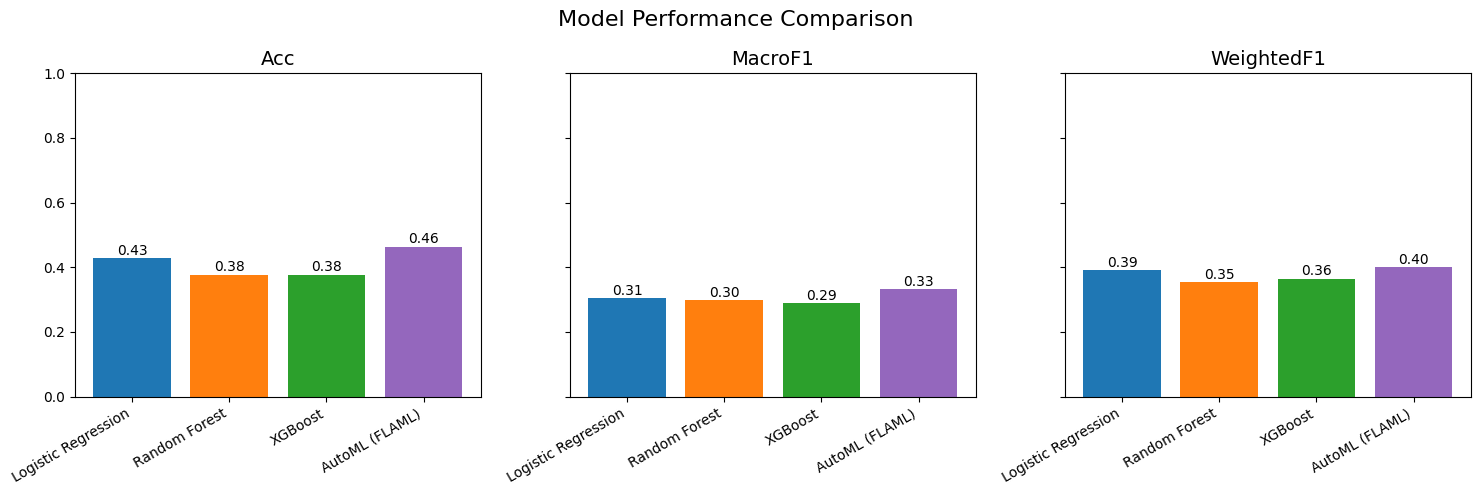

In [23]:
import matplotlib.pyplot as plt
metrics = ["Acc", "MacroF1", "WeightedF1"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, metric in enumerate(metrics):
    axes[i].bar(df_results["Method"], df_results[metric], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"])
    axes[i].set_title(metric, fontsize=14)
    axes[i].set_xticklabels(df_results["Method"], rotation=30, ha="right")
    axes[i].set_ylim(0, 1)
    for j, v in enumerate(df_results[metric]):
        axes[i].text(j, v + 0.01, f"{v:.2f}", ha="center", fontsize=10)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout()
plt.show()


Discussion

The comparative analysis indicates that AutoML (FLAML) achieved the highest overall accuracy (0.46) and weighted F1-score (0.40) among the evaluated models, outperforming Logistic Regression (0.43, 0.39), Random Forest (0.38, 0.35), and XGBoost (0.38, 0.36). Logistic Regression, despite its simplicity, demonstrated relatively competitive performance, suggesting that linear decision boundaries can still capture a meaningful portion of discriminative features in micro-expression embeddings. Random Forest and XGBoost, although popular ensemble methods, underperformed in this case, likely due to the high-dimensional nature of deep embeddings and the limited dataset size, which may have hindered their ability to generalize.

The results highlight clear trade-offs between predictive accuracy, interpretability, and computational complexity. Logistic Regression is straightforward to implement and highly interpretable, making it appealing in contexts requiring transparency and accountability. However, its linear nature constrains its ability to fully capture subtle, nonlinear dynamics of micro-expressions. Random Forest and XGBoost, while typically strong in tabular data tasks, may not be optimal for this type of feature space without additional tuning. AutoML provides a systematic advantage by automating hyperparameter search and model selection, but this comes at the cost of reduced interpretability and increased resource demands.

Beyond technical performance, the findings raise important considerations for the application of micro-expression recognition in social contexts. Deploying high-performing but opaque models, such as AutoML or gradient boosting, risks reinforcing algorithmic opacity in sensitive domains like law enforcement, security screening, or psychological assessment. This can undermine public trust and exacerbate concerns around bias, privacy, and surveillance. In contrast, simpler models such as Logistic Regression may offer greater transparency and accountability, albeit with modestly lower accuracy. The trade-off reflects a broader societal challenge: balancing performance gains with ethical responsibilities, including fairness, explainability, and the protection of individual rights.